In [16]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
from tqdm import tqdm 
import matplotlib.pyplot as plt
from quimb.tensor.tensor_1d import expec_TN_1D

N = 6
times = np.linspace(0, 10.0, 200)

hx, hy = 0.0, 0.0
Jx, Jy, Jz = 1.0, 1.0, 1.0
hz = [(np.random.uniform(-8.0, 8.0) + 4) / 2 for _ in range(N)]
alpha = 1.13

binary = ''.join([str((i+1) % 2) for i in range(N)])
print(f'Initial state: |{binary}>')
psi0 = qtn.MPS_computational_state(binary)
psi0.show()

max_bond = 14
cutoff = 1e-15

Initial state: |101010>
 1 1 1 1 1 
>─>─>─>─>─●
│ │ │ │ │ │


In [17]:
hz = [3.5002456640243587, 2.1348410418662898, 3.7939020763471074, 0.8076311318070069, -0.6941678763876196, 1.16944650425613]

In [19]:
XX = qu.kron(qu.pauli('X'), qu.pauli('X'))
YY = qu.kron(qu.pauli('Y'), qu.pauli('Y'))
ZZ = qu.kron(qu.pauli('Z'), qu.pauli('Z'))

H1 = {}
for i in range(N):
    H1[i] = hx * qu.pauli('X') \
          + hy * qu.pauli('Y') \
          + hz[i] * qu.pauli('Z')

l = 1
H2 = {}
for i in range(N):
    for j in range(i+1, min(i+l+1, N)):
        H2[(i, j)] = Jx / (np.abs(i-j)**alpha) * XX \
                   + Jy / (np.abs(i-j)**alpha) * YY \
                   + Jz / (np.abs(i-j)**alpha) * ZZ

H = qtn.LocalHam1D(L=N, H2=H2, H1=H1, cyclic=False)

tebd = qtn.TEBD(psi0, H)
tebd.split_opts['max_bond'] = max_bond
tebd.split_opts['cutoff'] = cutoff

mz_t_j = []
mz_t_total = []

for t_idx, psit in enumerate(tebd.at_times(times, tol=1e-3)):
    mzs = []
    bra = psit.H
    
    for j in range(N):
        sz_applied = psit.gate(qu.pauli('Z'), j, contract=True)
        mzs.append(expec_TN_1D(bra, sz_applied).real)
    
    mz_t_j.append(mzs)
    mz_t_total.append(sum(mzs))

mz_t_j = np.array(mz_t_j)
mz_t_total = np.array(mz_t_total)

corr_zz = np.zeros((len(times), N, N), dtype=np.complex128)

for j in tqdm(range(N), unit="j"):
    psi0_zj = psi0.gate(qu.pauli('Z'), j, contract=True)

    tebd = qtn.TEBD(psi0, H)
    tebd.split_opts['max_bond'] = max_bond
    tebd.split_opts['cutoff'] = cutoff

    tebd_z = qtn.TEBD(psi0_zj, H)
    tebd_z.split_opts['max_bond'] = max_bond
    tebd_z.split_opts['cutoff'] = cutoff

    for idx, t in enumerate(times):
        if idx > 0:
            tebd.update_to(t, dt=times[idx]-times[idx-1], progbar=False)
            tebd_z.update_to(t, dt=times[idx]-times[idx-1], progbar=False)

        for i in range(N):
            zi_psi_zj = tebd_z.pt.gate(qu.pauli('Z'), i, contract=True)
            corr_zz[idx, i, j] = expec_TN_1D(tebd.pt.H, zi_psi_zj).real

D = 0.5 * (1 - N**(-1) * np.trace(corr_zz, axis1=1, axis2=2)).real

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 6/6 [00:26<00:00,  4.43s/j]


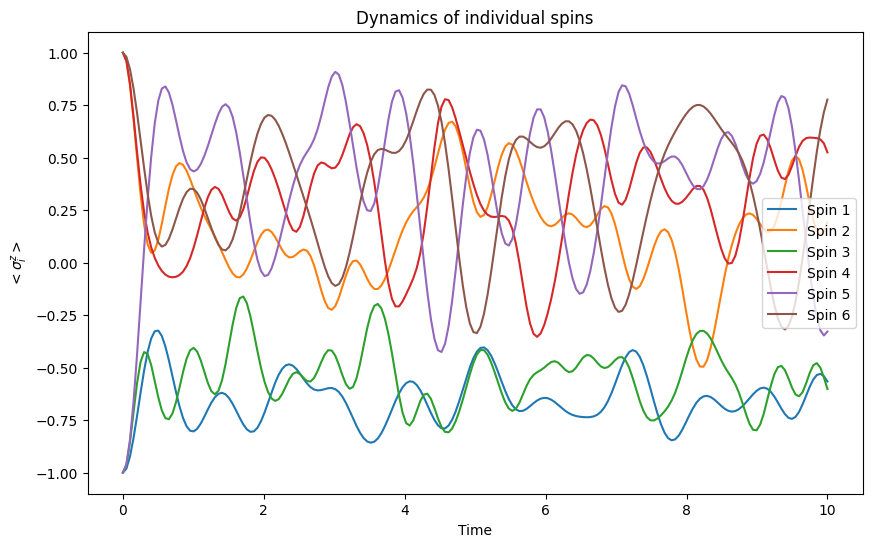

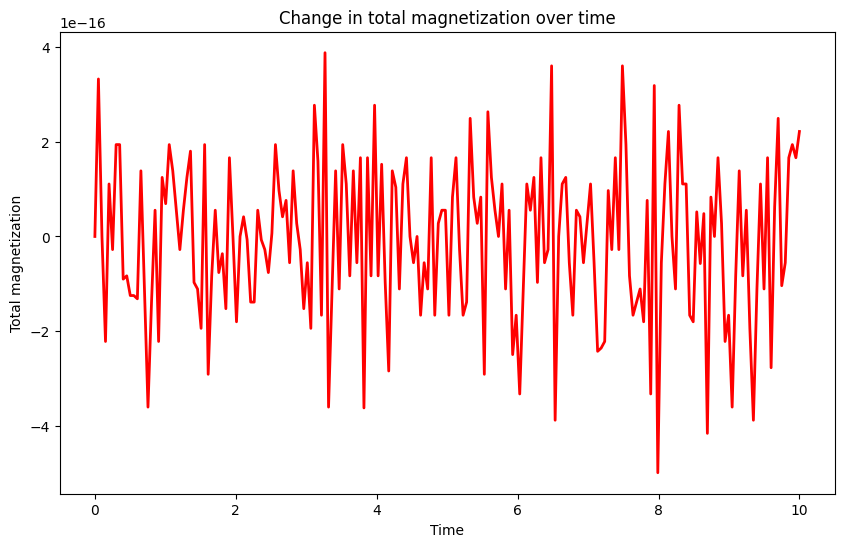

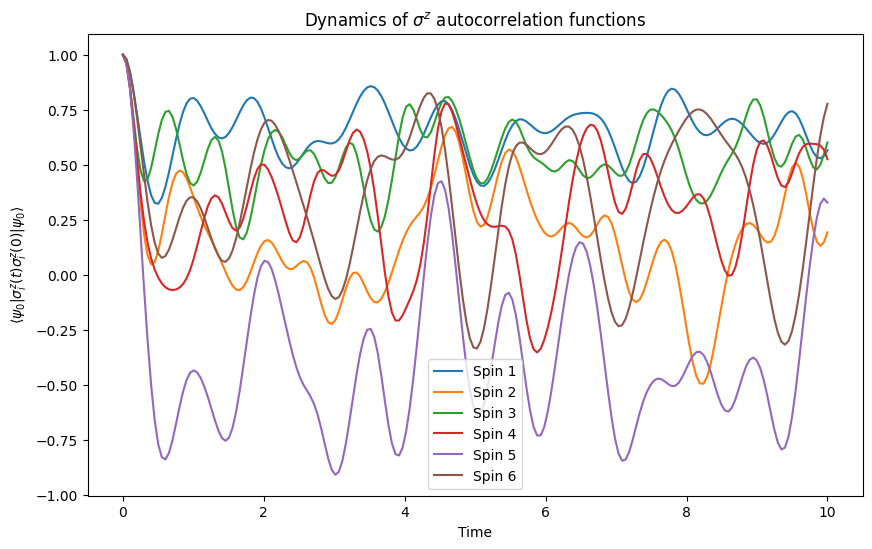

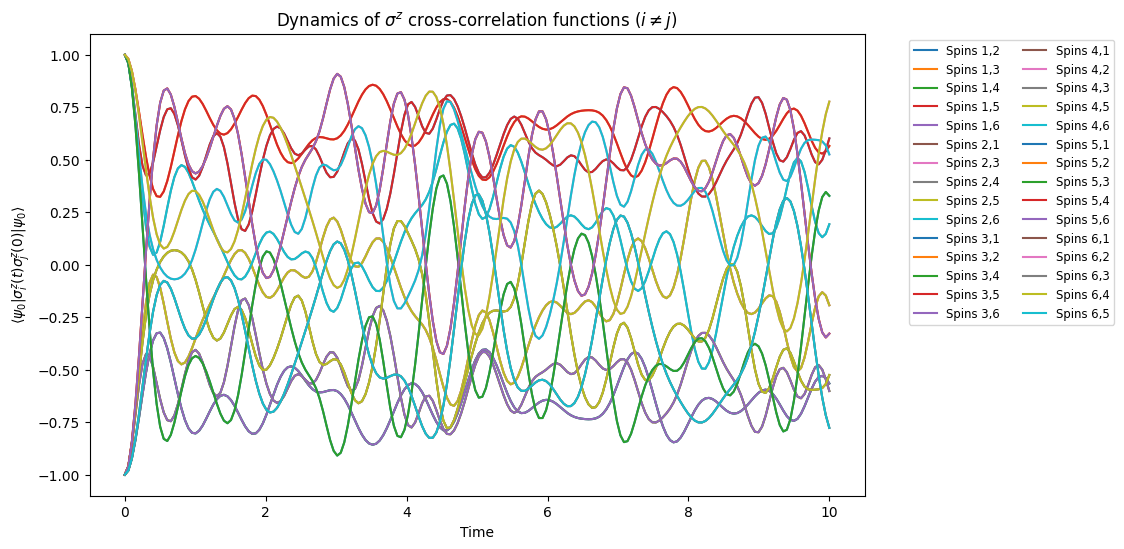

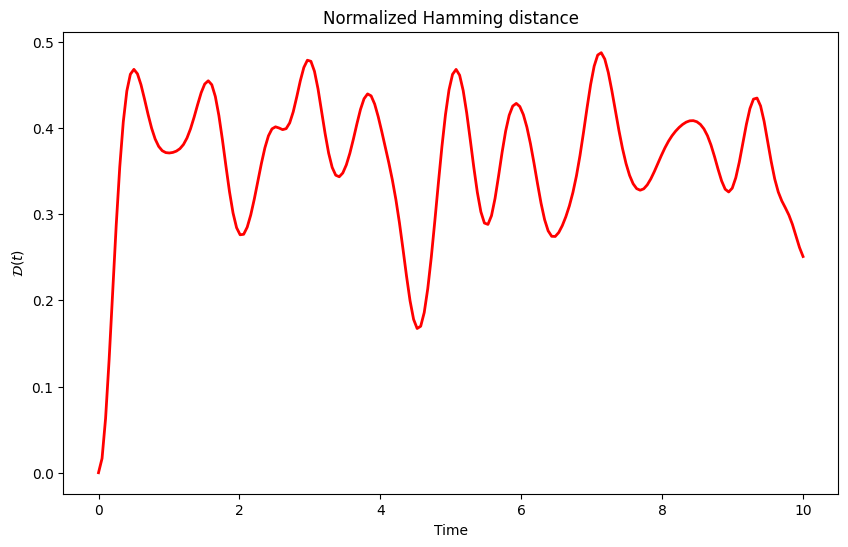

In [20]:
plt.figure(figsize=(10, 6))
for j in range(N):
    plt.plot(times, mz_t_j[:, j], label=f'Spin {j+1}')
plt.xlabel('Time')
plt.ylabel(r'$<\sigma^z_i>$')
plt.legend()
plt.title('Dynamics of individual spins')
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(times, mz_t_total, 'r-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Total magnetization')
plt.title('Change in total magnetization over time')
plt.show()

plt.figure(figsize=(10, 6))
for i in range(N):
    plt.plot(times, np.real(corr_zz[:, i, i]), label=f'Spin {i+1}')
plt.xlabel('Time')
plt.ylabel(r'$\langle \psi_0 | \sigma^z_i(t)\sigma^z_i(0) | \psi_0 \rangle$')
plt.legend()
plt.title(r'Dynamics of $\sigma^z$ autocorrelation functions')
plt.show()

plt.figure(figsize=(10, 6))
for i in range(N):
    for j in range(N):
        if i != j:
            plt.plot(times, np.real(corr_zz[:, i, j]), label=f'Spins {i+1},{j+1}')
plt.xlabel('Time')
plt.ylabel(r'$\langle \psi_0 | \sigma^z_i(t)\sigma^z_j(0) | \psi_0 \rangle$')
plt.title(r'Dynamics of $\sigma^z$ cross-correlation functions ($i \neq j$)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small', ncol=2)
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(times, D, 'r-', linewidth=2)
plt.xlabel('Time')
plt.ylabel(r'$\mathcal{D}(t)$')
plt.title('Normalized Hamming distance')
plt.show()

In [10]:
import quimb as qu
import quimb.tensor as qtn
import numpy as np
import matplotlib.pyplot as plt
from quimb.tensor.tensor_arbgeom_tebd import TEBDGen
import itertools
from tqdm import tqdm 
from collections.abc import Iterable

def Progbar(*args, **kwargs):
    kwargs.setdefault("ascii", True)
    return tqdm(*args, **kwargs)

class RealTimeTEBDGen(TEBDGen):
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.imag = False

    def sweep(self, tau):
        r"""Perform a full sweep of gates at every pair.

        .. math::

            \psi \rightarrow \prod_{\{ij\}} \exp(-I \tau H_{ij}) \psi

        """
        if callable(self.ordering):
            ordering = self.ordering()
        else:
            ordering = self.ordering

        if self.second_order_reflect:
            ordering = tuple(ordering) + tuple(reversed(ordering))
            factor = 2.0
        else:
            factor = 1.0

        layer = set()

        for where in ordering:
            if any(coo in layer for coo in where):
                # starting a new non-commuting layer
                self.postlayer()
                layer = set(where)
            else:
                # add to the current layer
                layer.update(where)

            if callable(tau):
                self.last_tau = tau(where)
            else:
                self.last_tau = tau

            G = self.ham.get_gate_expm(where, -1j * self.last_tau / factor)

            self.gate(G, where)

        self.postlayer()

    def compute_energy(self):
        """Compute and return the energy of the current state. Subclasses can
        override this with a custom method to compute the energy.
        """
        return self._psi.compute_local_expectation_cluster(
            terms=self.ham.terms, **self.compute_energy_opts
        ).real
    
    def evolve(self, steps, tau=None, progbar=None):
        """Evolve the state with the local Hamiltonian for ``steps`` steps with
        time step ``tau``.
        """
        if tau is not None:
            if isinstance(tau, Iterable):
                taus = itertools.chain(tau, itertools.repeat(tau[-1]))
            else:
                self.tau = tau
                taus = itertools.repeat(tau)

        if progbar is None:
            progbar = self.progbar

        pbar = Progbar(total=steps, disable=not progbar)

        try:
            for i, tau in zip(range(steps), taus):
                # anything required by both energy and sweep
                self.presweep(i)

                # possibly compute the energy
                should_compute_energy = bool(self.compute_energy_every) and (
                    i % self.compute_energy_every == 0
                )
                if should_compute_energy:
                    self._check_energy()
                    self._set_progbar_description(pbar)

                    # check for convergence
                    self.stop = (self.tol is not None) and (
                        self.energy_diffs[-1] < self.tol
                    )

                if self.stop:
                    # maybe stop pre sweep
                    self.stop = False
                    break

                # actually perform the gates
                self.sweep(tau)
                self.postsweep(i)

                self._n += 1
                pbar.update()
                self._set_progbar_description(pbar)

                if self.callback is not None:
                    if self.callback(self):
                        break

                if self.stop:
                    # maybe stop post sweep
                    self.stop = False
                    break

            # possibly compute the energy
            if self.compute_energy_final:
                self._check_energy()
                self._set_progbar_description(pbar)

        except KeyboardInterrupt:
            # allow the user to interupt early
            pass
        finally:
            pbar.close()

class RealTimeTEBD2D(RealTimeTEBDGen):
    def __init__(
        self,
        psi0,
        ham,
        tau=0.01,
        D=None,
        cutoff=1e-10,
        chi=None,
        imag=True,
        gate_opts=None,
        ordering=None,
        second_order_reflect=False,
        compute_energy_every=None,
        compute_energy_final=True,
        compute_energy_opts=None,
        compute_energy_fn=None,
        compute_energy_per_site=False,
        callback=None,
        keep_best=False,
        progbar=True,
    ):
        super().__init__(
            psi0=psi0,
            ham=ham,
            tau=tau,
            D=D,
            cutoff=cutoff,
            imag=imag,
            gate_opts=gate_opts,
            ordering=ordering,
            second_order_reflect=second_order_reflect,
            compute_energy_every=compute_energy_every,
            compute_energy_final=compute_energy_final,
            compute_energy_opts=compute_energy_opts,
            compute_energy_fn=compute_energy_fn,
            compute_energy_per_site=compute_energy_per_site,
            callback=callback,
            keep_best=keep_best,
            progbar=progbar,
        )

        # parse energy computation options
        if chi is None:
            chi = max(8, self.D**2)
        self.compute_energy_opts['max_bond'] = chi
        self.compute_energy_opts.setdefault('cutoff', 0.0)
        self.compute_energy_opts.setdefault('normalized', True)

    def compute_energy(self):
        """Compute and return the energy of the current state.
        """
        return self.state.compute_local_expectation(
            self.ham.terms,
            **self.compute_energy_opts
        ).real

    @property
    def chi(self):
        return self.compute_energy_opts['max_bond']

    @chi.setter
    def chi(self, value):
        self.compute_energy_opts['max_bond'] = round(value)

    def __repr__(self):
        s = "<{}(n={}, tau={}, D={}, chi={})>"
        return s.format(
            self.__class__.__name__, self.n, self.tau, self.D, self.chi)

Lx, Ly = 3, 3
hx, hy, hz = 1.0, 1.0, 1.0
Jx, Jy, Jz = -1.0, 1.0, 1.0

times = np.linspace(0, 10, 200)
dt = times[1] - times[0]

binary = '1' + '0' * (Lx * Ly - 1)
print(f'Initial state: |{binary}>')
site_map = []
for i in range(Lx):
    row = []
    for j in range(Ly):
        idx = i * Ly + j
        if binary[idx] == '1':
            vec = np.array([0.0, 1.0], dtype=np.complex128)
        else:
            vec = np.array([1.0, 0.0], dtype=np.complex128)
        row.append(vec)
    site_map.append(row)

psi0 = qtn.PEPS.product_state(site_map, cyclic=False, site_ind_id="k{0},{1}")
psi0.show()

Initial state: |100000000>
    1    1   
 ●━━━━●━━━━●
╱┃1  ╱┃1  ╱┃1  
 ┃  1 ┃  1 ┃ 
 ●━━━━●━━━━●
╱┃1  ╱┃1  ╱┃1  
 ┃  1 ┃  1 ┃ 
 ●━━━━●━━━━●
╱    ╱    ╱    


In [11]:
XX = qu.kron(qu.pauli('X'), qu.pauli('X'))
YY = qu.kron(qu.pauli('Y'), qu.pauli('Y'))
ZZ = qu.kron(qu.pauli('Z'), qu.pauli('Z'))

H2 = {}
for i in range(Lx):
    for j in range(Ly):
        if i < Lx - 1:
            H2[((i, j), (i + 1, j))] = Jx * XX + Jy * YY + Jz * ZZ
        if j < Ly - 1:
            H2[((i, j), (i, j + 1))] = Jx * XX + Jy * YY + Jz * ZZ

H1 = {}
for i in range(Lx):
    for j in range(Ly):
        H1[(i, j)] = hx * qu.pauli('X') \
                   + hy * qu.pauli('Y') \
                   + hz * qu.pauli('Z')

ham = qtn.LocalHam2D(Lx=Lx, Ly=Ly, H2=H2, H1=H1, cyclic=False)

tebd = RealTimeTEBD2D(psi0, ham, tau=dt, D=3, cutoff=1e-12)

mz_t_grid = []
mz_t_total = []

for it in range(len(times)):
    if it > 0:
        tebd.evolve(1, tau=dt)

    grid = np.zeros((Lx, Ly))
    tot = 0.0
    for i in range(Lx):
        for j in range(Ly):
            exp_val = tebd.state.compute_local_expectation({(i, j): qu.pauli('Z')})
            grid[i, j] = exp_val.real
            tot += exp_val
    mz_t_grid.append(grid)
    mz_t_total.append(tot)

mz_t_grid = np.array(mz_t_grid)
mz_t_total = np.array(mz_t_total)

n=199, tau=0.05, energy~-7.382: 100%|##########| 1/1 [00:00<00:00,  4.50it/s]   


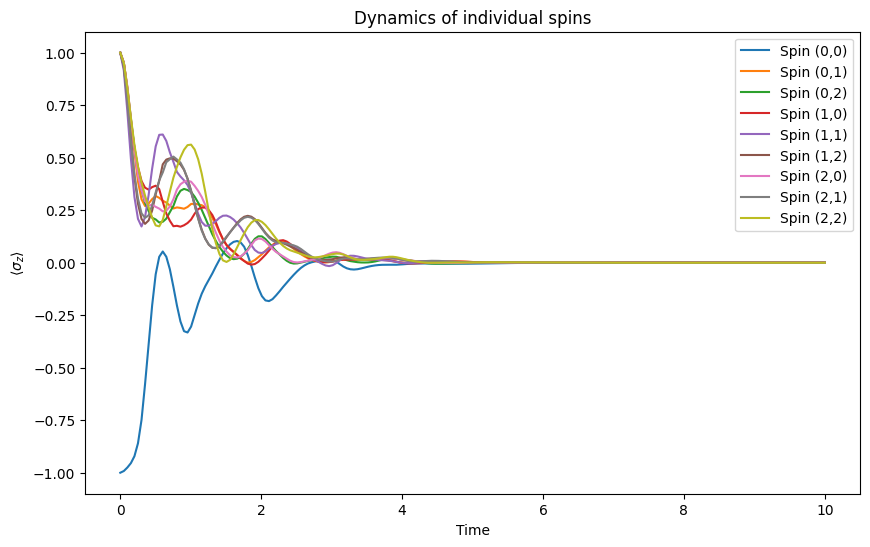

/home/yauhenitalochka/.conda/envs/pyenv/lib/python3.12/site-packages/matplotlib/cbook.py:1719: ComplexWarning: Casting complex values to real discards the imaginary part
  return math.isfinite(val)
/home/yauhenitalochka/.conda/envs/pyenv/lib/python3.12/site-packages/matplotlib/cbook.py:1355: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


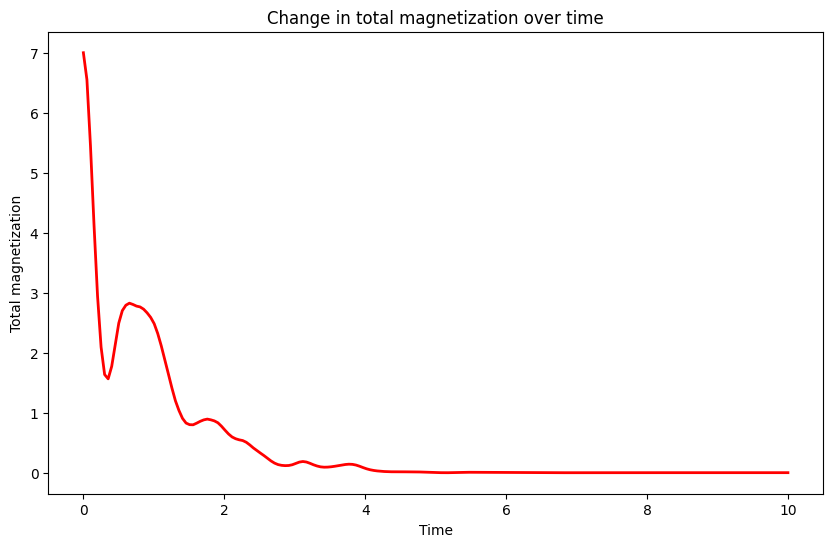

In [12]:
plt.figure(figsize=(10, 6))
for i in range(Lx):
    for j in range(Ly):
        plt.plot(times, mz_t_grid[:, i, j], label=f'Spin ({i},{j})')
plt.xlabel('Time')
plt.ylabel(r'$⟨σ_z⟩$')
plt.title('Dynamics of individual spins')
plt.legend()
plt.show()

plt.figure(figsize=(10, 6))
plt.plot(times, mz_t_total, 'r-', linewidth=2)
plt.xlabel('Time')
plt.ylabel('Total magnetization')
plt.title('Change in total magnetization over time')
plt.show()